# All the figures from the article that DO NOT relate to Deep Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tqdm.notebook import trange

import MotionClouds as mc
from LogGabor import LogGabor

from sporco import util
from sporco import signal
from sporco import plot
from sporco.admm import cbpdn
import sporco.metric as sm
from sporco.dictlrn import onlinecdl

from SLIP import Image, imread

import lmfit
from lmfit import Model, Parameters

import scipy.stats as stats
from scipy.io import loadmat

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
filter_size = 12 # size of each dico's element --> sqrt(LG size)
lg.set_size((filter_size, filter_size))

# Fig 1) Aleatoric variance in a natural image

In [4]:
from skimage.feature import hog

def compute_hog(image, N_thetas=64,feature_vector=False) :
    image = norm_data(image)
    fd = hog(image, orientations=N_thetas, pixels_per_cell=(32, 32),
                        cells_per_block=(1, 1), visualize=False, multichannel=True,
                       feature_vector = feature_vector, block_norm='L2', transform_sqrt = False)
    if feature_vector:
        return fd
    else:
        means = []
        for x in range(0, fd.shape[0]) :
            for y in range(0, fd.shape[1]) :
                means.append(fd[x,y,:,:,:])

        means = np.asarray(means)
        means = np.mean(means, axis = 0).ravel()
        return means
    
def plot_hog(hog_vals, ax,
             roll, color, do_label, alpha=1, edgecolor=None) :
    hog_vals = np.roll(hog_vals, roll)
    #hog_vals = norm_data(hog_vals)
        
    xs = np.linspace(0, np.pi, len(hog_vals))
    ax.bar(xs, hog_vals, align = 'center', width = xs[1] - xs[0],
          facecolor=color, edgecolor=edgecolor, alpha=alpha, lw=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.grid(True, which = 'major', axis = 'y', linestyle = '--')
    ax.set_axisbelow(True)
    
    if do_label :
        ax.set_xticks([0, np.pi/4,  np.pi/2, 3*np.pi/4, np.pi])
        ax.set_xticklabels(['-90°', '-45°', r'$\theta_{0}$', '+45°', '+90°'])
        ax.set_xticklabels(['0', '45', '90', '135', '180'])
        ax.tick_params(axis='both', labelsize=14)
        ax.set_xlabel('Orientation (°)', fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        
    else : 
        ax.set_xticks([0, np.pi/4,  np.pi/2, 3*np.pi/4, np.pi])
        ax.set_xticklabels([])
        #ax.set_yticklabels([])
        
    ax.set_ylim(np.min(hog_vals),
               np.max(hog_vals)+.01)
    return ax

def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def cirvar(bins):
    """Compute the circular variance for an array of bins.
    
    Parameters:
        bins (list or np.array): Array of bin counts, each representing a range of angles.
        
    Returns:
        float: Circular variance
    """
    N = np.sum(bins)  # Total number of data points
    num_bins = len(bins)
    bin_angles = np.linspace(0, 2 * np.pi, num_bins, endpoint=False)  # Bin representative angles
    avg_cos = np.sum(np.cos(bin_angles) * bins) / N
    avg_sin = np.sum(np.sin(bin_angles) * bins) / N
    R = np.sqrt(avg_cos ** 2 + avg_sin ** 2)
    var_circ = 1 - R
    return var_circ

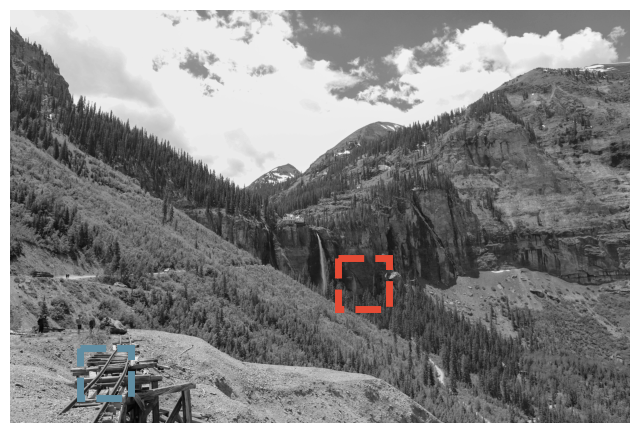

0.9249612723616062


C:\Users\Skorm\AppData\Local\Temp\ipykernel_1372\219644764.py:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(image, orientations=N_thetas, pixels_per_cell=(32, 32),


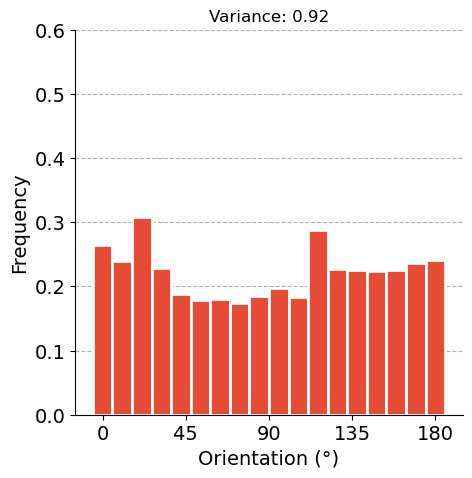

0.6680892023999603


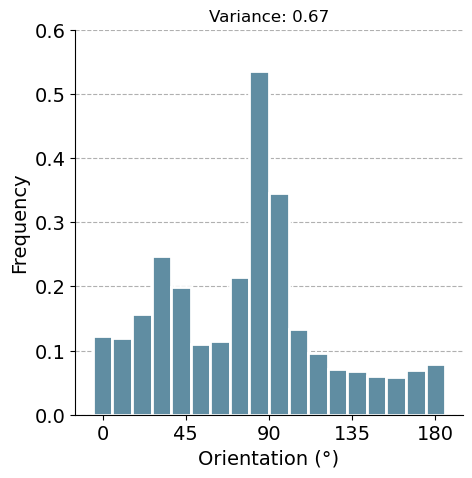

In [5]:
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import imageio 
coos = [(1250,1650),
    (1700, 350)]
width = 256
cols = ['#E64B35', '#608da2']
img = imageio.v2.imread('./imgs/all/IMG_7103.jpg')
img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
img = img[::2, ::2]

fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(img, cmap = plt.cm.gray)
ax.axis('off')
for i in range(2) :
    rect = Rectangle( (coos[i][1],coos[i][0]), width, width,
                    linewidth=5, edgecolor=cols[i], facecolor='none',
                    linestyle = '--')
    #ax.text(coos[i][1] + width + 50, coos[i][0] + 120, s = ['a', 'b', 'c', 'd'][i])
    ax.add_patch(rect)
fig.savefig('./figs/fig1_img.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
plt.show()

fig, ax = plt.subplots(figsize = (5,5), ncols = 1)

x,y,size = coos[0][0], coos[0][1], width
hog_data = compute_hog(img[x:x+size,y:y+size,None], N_thetas = 18)
ax = plot_hog(hog_data, ax, roll= 2, color = cols[0], do_label = True, edgecolor = 'w')
ax.set_title(f'Variance: {(cirvar(hog_data)):.2f}')

ax.set_ylim(0, .6)
print(cirvar(hog_data))
fig.savefig('./figs/fig1_hog_sharp.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
plt.show()


fig, ax = plt.subplots(figsize = (5,5), ncols = 1)

x,y,size = coos[1][0], coos[1][1], width
hog_data = compute_hog(img[x:x+size,y:y+size,None], N_thetas = 18)
ax = plot_hog(hog_data, ax, roll= 0, color = cols[1], do_label = True, edgecolor = 'w')
ax.set_title(f'Variance: {(cirvar(hog_data)):.2f}')


ax.set_ylim(0, .6)
print(cirvar(hog_data))
fig.savefig('./figs/fig1_hog_large.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
plt.show()

# Fig 1) Biological V1 receptive from Ringach's lab
## See this paper https://pubmed.ncbi.nlm.nih.gov/12091567/

In [6]:
load_path = './data/db_rf.mat'
data = loadmat(load_path)


nxs = data['db']['nx'][0][0][0]
nys = data['db']['ny'][0][0][0]
phis = data['db']['ph'][0][0][0]

In [7]:
def gabor(x, y, nx, ny, theta, A, phi=0.):
    # Calculate the frequency and the standard deviations
    f = np.sqrt(nx**2 + ny**2)
    sigma_x_prime = nx / f
    sigma_y_prime = ny / f

    # Calculate the rotated coordinates
    x_prime = x * np.cos(theta) + y * np.sin(theta)
    y_prime = -x * np.sin(theta) + y * np.cos(theta)

    # Calculate the Gabor function
    g = A * np.exp(-(x_prime**2 / (2 * sigma_x_prime**2) + y_prime**2 / (2 * sigma_y_prime**2))) * np.cos(2 * np.pi * f * x_prime + phi)
    
    return g


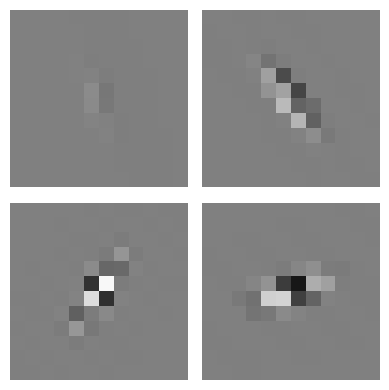

In [8]:
# Create a grid of x and y values
x = np.linspace(-3.5, 3.5, 12)
y = np.linspace(-3.5, 3.5, 12)
x, y = np.meshgrid(x, y)

gabors = list(zip(nxs, nys, phis))
gabors.sort(key=lambda g: g[1] / np.sqrt(g[0]**2 + g[1]**2), reverse=True)

fig, axs = plt.subplots(figsize = (4, 4), ncols = 2, nrows = 2)

for i, ax in enumerate(axs.flatten()) :
    # Calculate the Gabor function
    theta = np.random.uniform(0, np.pi)  # orientation not present in the paper...
    A = 1  # normalized amplitude
    nx = gabors[i][0]  # example value
    ny = gabors[i][1]  # example value
    phi = gabors[i][2]  # example value
    g = gabor(x, y, nx, ny, theta, A, phi)
    
    ax.imshow(g, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',
              vmin = -.75, vmax = .75,
             cmap = plt.cm.gray)
    ax.axis('off')
    
fig.tight_layout()
fig.savefig('./figs/fig_rf.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
plt.show()

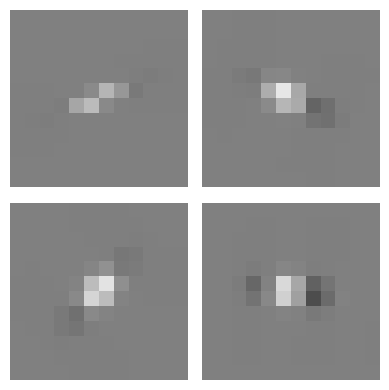

In [9]:
fig, axs = plt.subplots(figsize = (4, 4), ncols = 2, nrows = 2)
gabors = list(zip(nxs, nys, phis))
gabors.sort(key=lambda g: g[1] / np.sqrt(g[0]**2 + g[1]**2), reverse=False)
for i, ax in enumerate(axs.flatten()) :
    # Calculate the Gabor function
    theta = np.random.uniform(0, np.pi*2)  # orientation not present in the paper...
    A = 0.5  # normalized amplitude
    nx = gabors[i][0]  # example value
    ny = gabors[i][1]  # example value
    phi = gabors[i][2]  # example value
    g = gabor(x, y, nx, ny, theta, A, phi)

    
    ax.imshow(g, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',
              vmin = -.5, vmax = .5,
             cmap = plt.cm.gray)
    ax.axis('off')
    
fig.tight_layout()
fig.savefig('./figs/fig_rf_pt2.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
plt.show()

In [10]:
def dico_plot(dico, ncols, nrows,
              vmin = -1, vmax = 1, cmap = plt.cm.gray,
                wspace = .05, hspace = .05,
             fig_width = 10, fig_height = 10 ):
    
    fig, axs = plt.subplots(figsize = (fig_width, fig_height),
                          ncols = ncols, nrows = nrows)
    assert dico.shape[-1] == (ncols*nrows)
    axs = axs.flatten()
    for i in range(dico.shape[-1]) :
        axs[i].imshow(dico[:,:,i], interpolation = 'none', vmin = vmin, vmax = vmax, 
                     cmap = cmap)
        axs[i].axis('off')

    plt.subplots_adjust(wspace = wspace, hspace = hspace)
    return fig, axs

LogGabor with Btheta


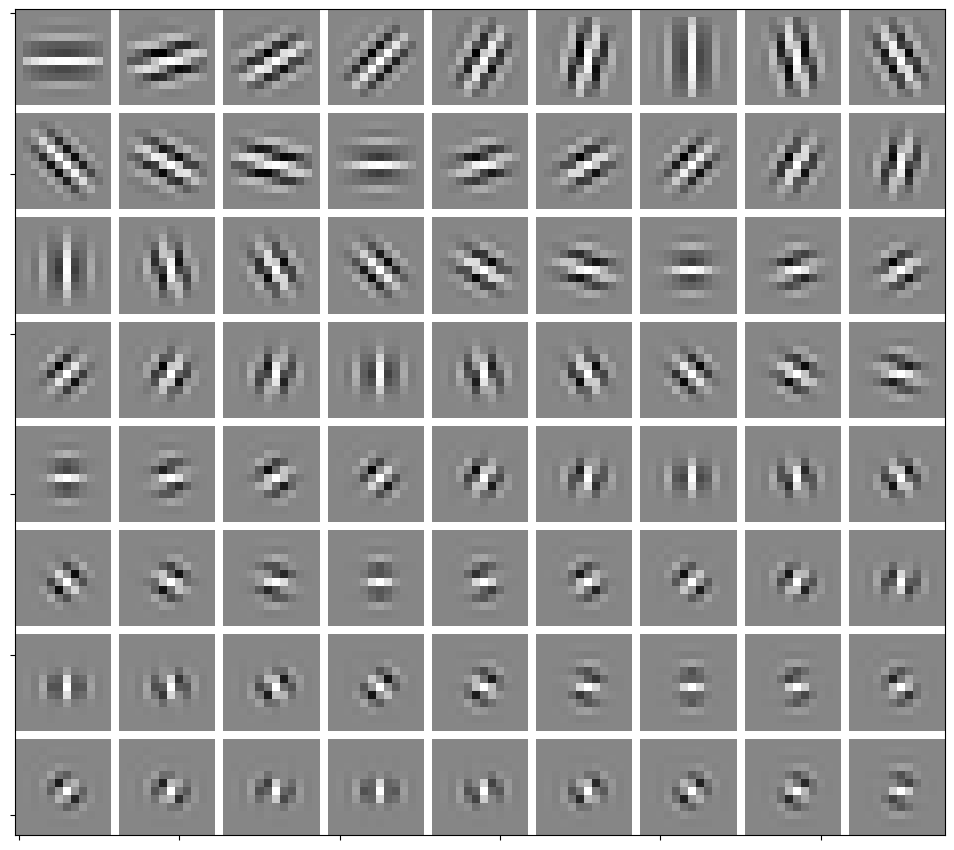

(12, 12, 72)


In [12]:
i_ = 0
N_theta, N_Btheta, N_phase = 12, 6, 1
thetas = np.linspace(0, np.pi, N_theta, endpoint = False)
phases = np.linspace(0, np.pi, N_phase, endpoint=False)
B_thetas = np.linspace(0, np.pi/6, N_Btheta+1, endpoint = True)[1:]
K = N_theta * N_Btheta * N_phase
K = N_theta * N_Btheta * N_phase
D = np.zeros((filter_size, filter_size, K))
for i_Btheta in range(N_Btheta):
    for i_theta in range(N_theta):
        for i_phase in range(N_phase):
            #print(i_)
            params= {'sf_0':.4, 'B_sf': lg.pe.B_sf, 'theta':thetas[i_theta], 'B_theta': B_thetas[i_Btheta]}
            env = lg.loggabor(filter_size // 2, filter_size // 2, **params) * np.exp(-1j * phases[i_phase])
            D[:, :, i_] = lg.normalize(lg.invert(env)*lg.mask)
            i_ += 1

    
print('LogGabor with Btheta')
fig, ax = plot.imview(util.tiledict(D), fgsz=(12, 12))
plt.show()
fig.tight_layout()
fig.savefig('./figs/fig_1_dico.pdf', bbox_inches = 'tight', transparent = True, dpi = 200)
print(D.shape)